# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, split, udf, isnull
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify Project") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# read the data from the json file
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
# number of rows and columns in the data
print("The number of rows in the dataframe: {}".format(df.count()))
print("The number of columns in the dataframe: {}".format(len(df.columns)))

The number of rows in the dataframe: 286500
The number of columns in the dataframe: 18


In [7]:
# show the columns of the data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# the first row of the data
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [9]:
# userId & sessionId missing values
userId_nan = df.filter(isnull(col("userId"))).count()
sessionId_nan = df.filter(isnull(col("sessionId"))).count()
print("The number of missing values in userId column: {}".format(userId_nan))
print("The number of missing values in sessionId column: {}".format(sessionId_nan))

The number of missing values in userId column: 0
The number of missing values in sessionId column: 0


In [10]:
# drop rows of missing values of userId or sessionId
df = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [11]:
# count userId empty values
userId_empty = df.filter(df.userId == "").count()
print("The number of empty values in userId column: {}".format(userId_empty))

The number of empty values in userId column: 8346


In [12]:
# remove records with empty userId
df = df.filter(df.userId != '')

In [13]:
# stats about the data
df.describe(df.columns[:6]).show()
df.describe(df.columns[6:13]).show()
df.describe(df.columns[13:]).show()

+-------+------------------+---------+---------+------+------------------+--------+
|summary|            artist|     auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+---------+---------+------+------------------+--------+
|  count|            228108|   278154|   278154|278154|            278154|  278154|
|   mean| 551.0852017937219|     null|     null|  null|114.89918174824018|    null|
| stddev|1217.7693079161374|     null|     null|  null|  129.851729399489|    null|
|    min|               !!!|Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged In|   Zyonna|     M|              1321|  Wright|
+-------+------------------+---------+---------+------+------------------+--------+

+-------+-----------------+------+-----------------+------+-------+--------------------+------------------+
|summary|           length| level|         location|method|   page|        registration|         sessionId|
+-------+-----------------+

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# create new columns with clear representation for the timestamp and registration
update_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('new_registration', update_time(col('registration')))
df = df.withColumn('new_ts', update_time(col('ts')))

In [15]:
# create a new column "churn" to label cancellation events
churn_label = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn_label("page"))

# create a new column "downgrade" to label downgrade events
downgrade_label  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade", downgrade_label("page"))

In [16]:
# create an additive "Fsum" (from 0 to n-1 phases) window for churn and downgrade phases
downgrade_window = Window.partitionBy('UserId').orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

df = df.withColumn("downgrade_phase", Fsum('downgrade').over(downgrade_window))

churn_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

df = df.withColumn("churn_phase", Fsum('churn').over(churn_window))

In [17]:
# Number of active and cancelled users 
df.drop_duplicates(['userId']).groupby(['churn_phase']).count().sort("churn_phase").show()

+-----------+-----+
|churn_phase|count|
+-----------+-----+
|          0|  173|
|          1|   52|
+-----------+-----+



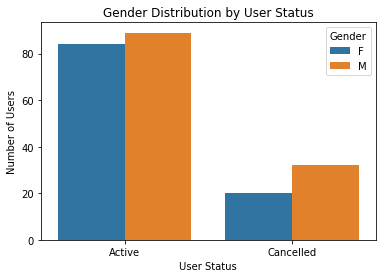

In [18]:
# Gender Distribution by User Status Plot
churn_gender = df.drop_duplicates(['userId', 'gender']).groupby(['churn_phase', 'gender']).count() \
                .sort("churn_phase").toPandas()

sns.barplot(data=churn_gender, x='churn_phase', y='count', hue='gender')
plt.title("Gender Distribution by User Status")
plt.xlabel("User Status")
plt.ylabel("Number of Users")
user_status = ['Active', 'Cancelled']
plt.xticks(np.arange(len(user_status)), user_status)
plt.legend(title='Gender');

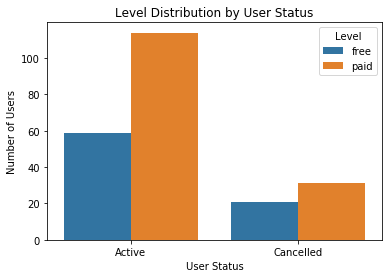

In [19]:
# Level Distribution by User Status Plot
churn_level = df.drop_duplicates(['userId']).groupby(['churn_phase', 'level']).count() \
            .sort("churn_phase").toPandas()

sns.barplot(data=churn_level, x='churn_phase', y='count', hue='level')
plt.title("Level Distribution by User Status")
plt.xlabel("User Status")
plt.ylabel("Number of Users")
plt.xticks(np.arange(len(user_status)), user_status)
plt.legend(title='Level');

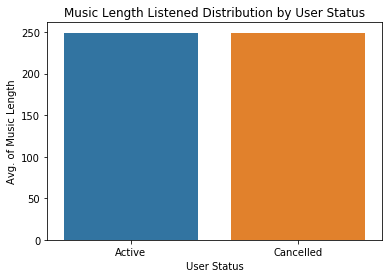

In [20]:
# Avg. Music Length Listened Distribution by User Status Plot
churn_length = df.groupby('churn_phase').avg().select('churn_phase', 'avg(length)') \
                .sort("churn_phase").toPandas()

sns.barplot(data=churn_length, x='churn_phase', y='avg(length)')
plt.title("Music Length Listened Distribution by User Status")
plt.xlabel("User Status")
plt.ylabel("Avg. of Music Length")
plt.xticks(np.arange(len(user_status)), user_status);

In [21]:
# the different types of pages/events
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



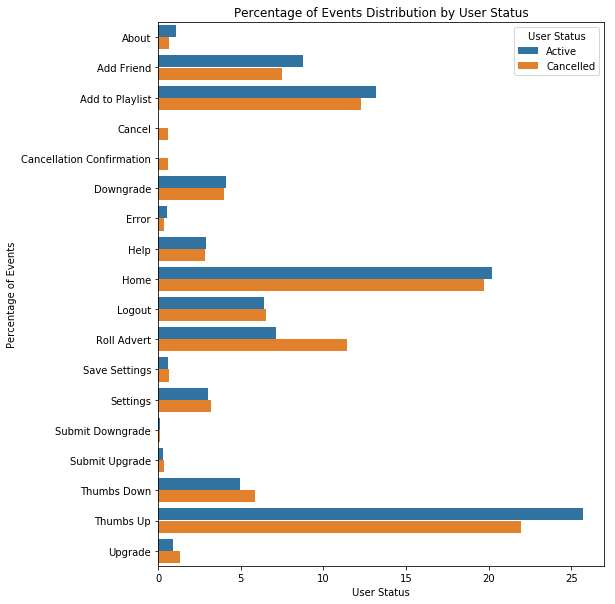

In [22]:
# Percentage of Events Distribution by User Status
churn_page = df.groupby(['page','churn_phase']).count().sort(["page", "churn_phase"]).toPandas()
## remove NextSong event since it will cover the main percetage in each churn class (0 & 1)
churn_page = churn_page[churn_page['page'] != 'NextSong']
churn_page = ((churn_page.groupby(['page','churn_phase']).sum()/churn_page.groupby(['churn_phase']).sum())*100) \
            .reset_index()

churn_page['churn_phase'] = churn_page['churn_phase'].replace({0:'Active', 1: 'Cancelled'})
                                                      
plt.figure(figsize=(8,10))
sns.barplot(data=churn_page, x='count', y='page', hue="churn_phase")
plt.title("Percentage of Events Distribution by User Status")
plt.xlabel("User Status")
plt.ylabel("Percentage of Events")
plt.legend(title='User Status');

In [23]:
# create a column of the hour of the event 
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn("hour", get_hour(df.ts))

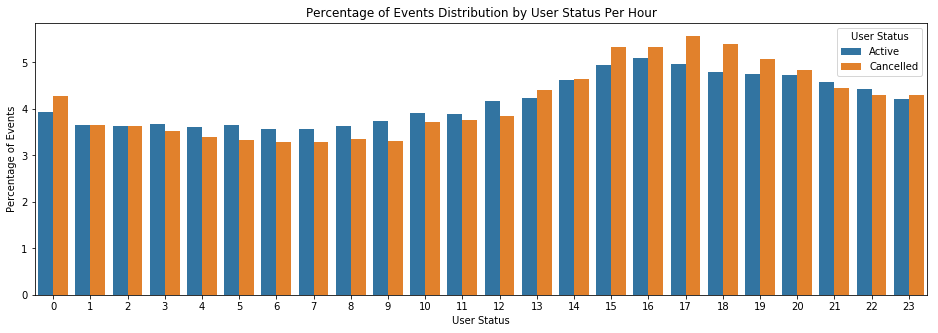

In [24]:
# Percentage of Events Distribution by User Status Per Hour
churn_hour = df.groupby(['hour','churn_phase']).count().toPandas()
churn_hour = ((churn_hour.groupby(['hour','churn_phase']).sum()/churn_hour.groupby(['churn_phase']).sum())*100) \
            .reset_index()

churn_hour['hour'] = churn_hour['hour'].astype(int)
churn_hour = churn_hour.sort_values(by = ['hour', 'churn_phase'])
churn_hour['churn_phase'] = churn_hour['churn_phase'].replace({0:'Active', 1: 'Cancelled'})

plt.figure(figsize=(16,5))
sns.barplot(data=churn_hour, x='hour', y='count', hue="churn_phase")
plt.title("Percentage of Events Distribution by User Status Per Hour")
plt.xlabel("User Status")
plt.ylabel("Percentage of Events")
plt.legend(title='User Status');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [25]:
# Feature 1: gender of the user
user_gender = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender') \
             .select('userId', col('gender').cast('int'))

In [26]:
# Feature 2: Total time of listened length
listen_time = df.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'listen_time')

In [27]:
# Feature 3: Number of songs listened
num_songs = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'num_songs')

In [28]:
# Feature 4 : Total number of artists the user has listened to
num_artists = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count() \
             .withColumnRenamed("count", "num_artists")

In [29]:
# Feature 5: Avg. time spent in the platform
spend_time = df.select('userId', 'registration', 'ts').withColumn('spend_time', (df.ts-df.registration)) \
            .select('userId', 'spend_time').groupBy('userId').avg() \
            .withColumnRenamed('avg(spend_time)', 'avg_spend_time')

In [30]:
# Feature 6: Number of thumbs up
num_thumb_up = df.select('userId','page').filter(df.page == "Thumbs Up").groupby("userId").count() \
                .withColumnRenamed('count', 'num_thumb_up')

# Feature 7: Number of thumbs down
num_thumb_down = df.select('userId','page').filter(df.page == "Thumbs Down").groupby("userId").count() \
                .withColumnRenamed('count', 'num_thumb_down')

In [31]:
# Feature 8: Number of adds to playlist
num_add_playlist = df.select('userId','page').filter(df.page == "Add to Playlist").groupby("userId").count() \
                .withColumnRenamed('count', 'num_add_playlist')

In [32]:
# Feature 9: Number of upgrades
num_upgrade = df.select('userId','page').filter(df.page == "Submit Upgrade").groupby("userId").count() \
                .withColumnRenamed('count', 'num_upgrade')

# Feature 10: Number of downgrades
num_downgrade = df.select('userId','page').filter(df.page == "Submit Downgrade").groupby("userId").count() \
                .withColumnRenamed('count', 'num_downgrade')

In [33]:
# Feature 11: Number of roll advert
num_advert = df.select('userId','page').filter(df.page == "Roll Advert").groupby("userId").count() \
                .withColumnRenamed('count', 'num_advert')

In [34]:
# Feature 12: Number of friends
num_friends = df.select('userId','page').filter(df.page == "Add Friend").groupby("userId").count() \
                .withColumnRenamed('count', 'num_friends')

In [35]:
# Feature 13: Number of help 
num_help = df.select('userId','page').filter(df.page == "Help").groupby("userId").count() \
                .withColumnRenamed('count', 'num_help')

# Feature 14: Number of error
num_error = df.select('userId','page').filter(df.page == "Error").groupby("userId").count() \
                .withColumnRenamed('count', 'num_error')

In [36]:
# combine all the features on the userId
features = user_gender.join(listen_time, "userId") \
        .join(num_songs, "userId") \
        .join(num_artists, "userId") \
        .join(spend_time, "userId") \
        .join(num_thumb_up, "userId") \
        .join(num_thumb_down, "userId") \
        .join(num_add_playlist, "userId") \
        .join(num_upgrade, "userId") \
        .join(num_downgrade, "userId") \
        .join(num_advert, "userId") \
        .join(num_friends, "userId") \
        .join(num_help, "userId") \
        .join(num_error, "userId") \

In [37]:
# set churn as the label
label = df.select('userId', col('churn_phase').alias('label')).dropDuplicates()

In [38]:
# join the features and label
data = features.join(label, "userId").drop("userId")

In [39]:
# create a vector for the features
feature_col = data.columns
feature_col.remove("label")
assembler = VectorAssembler(inputCols=feature_col, outputCol="features_vec")
data = assembler.transform(data)

In [40]:
# scale the data with Standard Scaler
scaler = StandardScaler(inputCol="features_vec", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.